In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata
import string
import gc
from anndata import read_h5ad
from anndata import read_csv
from pandas import DataFrame
import h5py
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA
import networkx as nx
import plotly.graph_objects as go
import scanpy as sc
from cnmf import cNMF
import pickle
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import normalize
import warnings
import dill
from gprofiler import GProfiler
import colorcet as cc
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from collections import Counter, defaultdict

/home/anton.thieme/miniconda3/envs/sc_env_cnmf/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


In [2]:
dill.load_session('sessions/002-cnmf_dtc.pkl')

In [75]:
dill.dump_session('sessions/002-cnmf_dtc.pkl')

## PREPARE DATA

In [ ]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
adata_tf

In [ ]:
adata_tf.X.max()

In [ ]:
for donor in adata_tf.obs['donor'].unique():
    print(donor)
    adata_tf_donor = adata_tf[adata_tf.obs['donor'] == donor]
    for tissue in adata_tf_donor.obs['tissue'].unique():
        print(tissue)
        adata_tf_donor_tissue = adata_tf_donor[adata_tf_donor.obs['tissue'] == tissue]
        for celltype in adata_tf_donor_tissue.obs['broad_cell_class'].unique():
            print(celltype)
            adata_tf_donor_tissue_celltype = adata_tf_donor_tissue[adata_tf_donor_tissue.obs['broad_cell_class'] == celltype]
            adata_tf_donor_tissue_celltype.write_h5ad(os.path.join('..', 'data', 'donor_tissue_celltype_split', 'adata_tf_' + donor + '_' + tissue + '_' + celltype + '.h5ad'))
            del adata_tf_donor_tissue_celltype
            gc.collect()

In [ ]:
for celltype in adata_tf.obs['broad_cell_class'].unique():
    try:
        os.makedirs(os.path.join('..', 'data', 'donor_tissue_celltype_split', celltype))    
        for filename in os.listdir('../data/donor_tissue_celltype_split'):
            if filename.endswith('.h5ad') and celltype in filename:
                os.rename(os.path.join('../data/donor_tissue_celltype_split', filename), os.path.join('../data/donor_tissue_celltype_split', celltype, filename))
    except FileExistsError as e:
        print(f'error caught: {e}')



In [3]:
sc.pp.filter_cells(adata_tf, min_genes=3) # filter cells with fewer than 3 genes
#sc.pp.filter_cells(adata_tf, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata_tf, min_cells=3) # filter genes detected in fewer than 3 cells

In [4]:
sc.write(os.path.join('..', 'data', 'adata_tf_cnmf.h5ad'), adata_tf)

## RUN CNMF

follow tutorial from here: https://github.com/dylkot/cNMF/blob/master/Tutorials/analyze_pbmc_example_data.ipynb

run it using the run_cnmf_dtc.py script and the run_cnmf_dtc.sh shell script.

## Analyze Results

The run created a K selection plot. K corresponds to the number of gene expression programs that we will distinguish. Since we are looking at donor, tissue, celltype split data, we expect a relativeley homogeneous population and for there to be only few distinct gene expression programs. 

In [ ]:
for ct in os.listdir(os.path.join(base_path, run)):
    for f in os.listdir(os.path.join(base_path, run, ct)):
        if ~f.endswith('.pkl'):
            try:
                dir_path = os.path.join(base_path, run, ct, f)
                file_path = dir_path + '_cnmf_obj.pkl'
                file_name = f + '_cnmf_obj.pkl'
                os.rename(file_path, os.path.join(dir_path, file_name))
            except Exception as e:
                print(f'error caught: {e}')

## Comparing large number of datasets

### Define Run Parameters

In [4]:
# Paths and parameters
base_path = os.path.join('..', 'results', 'cnmf')
run = 'tf_cNMF_dtc/17753102'
selected_k = 5
density_threshold = 2.00

In [ ]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
broad_cell_classes = adata_tf.obs['broad_cell_class'].unique()
cts = broad_cell_classes.to_list()
cts

### Restructure if necessary

In [ ]:
# run when all is done if necessary

dtc_dir = False
dtc_dir_content = True
cnmf_temp_dir = False

for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for dtc in os.listdir(os.path.join(base_path, run, celltype)):
        print(f'DTC: {dtc}')

        if dtc_dir:
        
            #os.rename(os.path.join(base_path, run, celltype, dtc), os.path.join(base_path, run, celltype, dtc[1:].replace(' ', '_')))
            print(os.path.join(base_path, run, celltype, dtc[1:].replace(' ', '_')))
            tmp = dtc[1:].replace(' ', '_')
            donor = tmp[:tmp.index('-')]
            tissue = tmp[tmp.index('-')+1:tmp.rfind('-')].replace('-', '_')
            ct = tmp[tmp.rfind('-')+1:]
            print(donor)
            print(tissue)
            print(ct)
            print(os.path.join(base_path, run, celltype, '-'.join([donor, tissue, ct])))
            os.rename(os.path.join(base_path, run, celltype, dtc), os.path.join(base_path, run, celltype, '-'.join([donor, tissue, ct])))

        if dtc_dir_content:
            for f in os.listdir(os.path.join(base_path, run, celltype, dtc)):
                if f.startswith('-'):
                    tmp = f[1:f.index('.')]
                    tmp_2 = f[f.index('.')-1:]
                    print(tmp)
                    donor = tmp[:tmp.index('-')]
                    tissue = tmp[tmp.index('-')+1:tmp.rfind('-')].replace('-', '_')
                    ct = tmp[tmp.rfind('-')+1:]
                    new_dtc = '-'.join([donor, tissue, ct])
                    new_f = new_dtc + tmp_2
                    print(new_dtc)
        


In [ ]:
dtc_dir = True
for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for dtc in os.listdir(os.path.join(base_path, run, celltype)):
        print(f'DTC: {dtc}')

        if dtc_dir:
            # Reverse the renaming of directories
            donor, tissue, ct = dtc.split('-')
            tissue = tissue.replace('_', '-')
            original_dtc = f'{donor}-{tissue}-{ct}'
            print(os.path.join(base_path, run, celltype, original_dtc))
            os.rename(os.path.join(base_path, run, celltype, dtc), os.path.join(base_path, run, celltype, original_dtc))


In [ ]:
for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for dtc in os.listdir(os.path.join(base_path, run, celltype)):
        print(f'DTC: {dtc}')

        if dtc_dir_content:
            for f in os.listdir(os.path.join(base_path, run, celltype, dtc)):
                if f.startswith('-'):
                    print(f)
                    new_f = f[1:]
                    os.rename(os.path.join(base_path, run, celltype, dtc, f), os.path.join(base_path, run, celltype, dtc, new_f))
                
                if os.path.isdir(os.path.join(base_path, run, celltype, dtc, f)):
                    for ff in os.listdir(os.path.join(base_path, run, celltype, dtc, f)):
                        if ff.startswith('-'):
                            print(ff)
                            new_ff = ff[1:]
                            os.rename(os.path.join(base_path, run, celltype, dtc, f, ff), os.path.join(base_path, run, celltype, dtc, f, new_ff))
        

### Load Results

In [6]:
# Initialize storage for GEPs and dataset labels
all_geps = []
dataset_labels = []
error_dtcs = []

# Iterate through cell types and DTC directories
for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for dtc in os.listdir(os.path.join(base_path, run, celltype)):
        print(f'DTC: {dtc}')

        try:
        
            # Load the cNMF object
            with open(os.path.join(base_path, run, celltype, dtc, 'cnmf_obj.pkl'), 'rb') as f:
                cnmf_obj = pickle.load(f)

            # Update paths in cnmf_obj to ensure correct usage
            for key in cnmf_obj.paths.keys():
                path = cnmf_obj.paths[key]
                cnmf_obj.paths[key] = path[3:]  # Remove leading '../'

            # Generate consensus matrix and load results
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning) 
                cnmf_obj.consensus(k=selected_k, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=True)
                results = cnmf_obj.load_results(K=selected_k, density_threshold=density_threshold, n_top_genes=10)

            # Access `H` from the first dictionary in `results`
            geps = results[1]  # `H` is the gene-by-program matrix
            geps.dropna(inplace=True)
            geps_norm = normalize(geps, axis=0)  # Normalize GEPs by their L2 norm

            # Store normalized GEPs and associated dataset labels
            all_geps.append(geps_norm.T)  # Transpose: programs x genes
            dataset_labels.extend([f'{celltype}_{dtc}'] * geps_norm.shape[1])  # Label programs by dataset

        except Exception as e:
            print(f'Error processing {dtc}: {e}')
            error_dtcs.append(dtc)

print(f'Successfully retrieved GEPs for {len(all_geps)} datasets.')
print(f'Failed to retrieve GEPs for {len(error_dtcs)} datasets.')

Celltype: adventitial cell
DTC: TSP14-Lung-adventitial cell
DTC: TSP14-Salivary-Gland-adventitial cell
DTC: TSP25-Lung-adventitial cell
DTC: TSP7-Salivary-Gland-adventitial cell
Celltype: ciliated epithelial cell
DTC: TSP1-Lung-ciliated epithelial cell
DTC: TSP14-Lung-ciliated epithelial cell
DTC: TSP2-Lung-ciliated epithelial cell
DTC: TSP2-Trachea-ciliated epithelial cell
DTC: TSP21-Trachea-ciliated epithelial cell
DTC: TSP21-Uterus-ciliated epithelial cell
DTC: TSP25-Lung-ciliated epithelial cell
DTC: TSP6-Trachea-ciliated epithelial cell
Celltype: connective tissue cell
DTC: TSP2-Trachea-connective tissue cell
Celltype: contractile cell
DTC: TSP1-Bladder-contractile cell
DTC: TSP1-Lung-contractile cell
DTC: TSP1-Muscle-contractile cell
DTC: TSP10-Fat-contractile cell
DTC: TSP10-Skin-contractile cell
DTC: TSP12-Heart-contractile cell
DTC: TSP14-Bladder-contractile cell
DTC: TSP14-Fat-contractile cell
DTC: TSP14-Lung-contractile cell
DTC: TSP14-Muscle-contractile cell
DTC: TSP14-Sali

all_geps has shape: (#dtc, #GEPs, #genes)

## Consolidate GEPs for further analysis

In [7]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
gene_names = adata_tf.var_names

In [25]:
gep_df = pd.DataFrame(index=gene_names)

for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for i, dtc in enumerate(os.listdir(os.path.join(base_path, run, celltype))):
        if not dtc in error_dtcs:
            print(f'DTC: {dtc}')
            genes_tmp = pd.read_csv(os.path.join(base_path, run, celltype, dtc, 'genes.tsv'), sep='\t', header=None)
            genes_tmp.set_index(keys=0, inplace=True)
            genes_tmp.drop(columns=[1], inplace=True)
            print(f'len(genes_tmp): {len(genes_tmp)}')
            dataset_id = int(dataset_labels.index(celltype + '_' + dtc) / 5)
            print(f'dataset_id: {dataset_id}')
            for ii in range(selected_k):
                gep = all_geps[dataset_id][ii]
                print(f'len(gep): {len(gep)}')
                genes_tmp['gep_' + dtc + '_' + str(ii)] = gep

            gep_df = gep_df.join(genes_tmp, how='left')

            

Celltype: adventitial cell
DTC: TSP14-Lung-adventitial cell
len(genes_tmp): 172
dataset_id: 0
len(gep): 172
len(gep): 172
len(gep): 172
len(gep): 172
len(gep): 172
DTC: TSP14-Salivary-Gland-adventitial cell
len(genes_tmp): 257
dataset_id: 1
len(gep): 257
len(gep): 257
len(gep): 257
len(gep): 257
len(gep): 257
DTC: TSP25-Lung-adventitial cell
len(genes_tmp): 268
dataset_id: 2
len(gep): 268
len(gep): 268
len(gep): 268
len(gep): 268
len(gep): 268
DTC: TSP7-Salivary-Gland-adventitial cell
len(genes_tmp): 306
dataset_id: 3
len(gep): 306
len(gep): 306
len(gep): 306
len(gep): 306
len(gep): 306
Celltype: ciliated epithelial cell
DTC: TSP1-Lung-ciliated epithelial cell
len(genes_tmp): 301
dataset_id: 4
len(gep): 301
len(gep): 301
len(gep): 301
len(gep): 301
len(gep): 301
DTC: TSP14-Lung-ciliated epithelial cell
len(genes_tmp): 267
dataset_id: 5
len(gep): 267
len(gep): 267
len(gep): 267
len(gep): 267
len(gep): 267
DTC: TSP2-Lung-ciliated epithelial cell
len(genes_tmp): 317
dataset_id: 6
len(gep)

In [26]:
gep_df.fillna(0, inplace=True)
gep_df


,gep_TSP14-Lung-adventitial cell_0,gep_TSP14-Lung-adventitial cell_1,gep_TSP14-Lung-adventitial cell_2,gep_TSP14-Lung-adventitial cell_3,gep_TSP14-Lung-adventitial cell_4,gep_TSP14-Salivary-Gland-adventitial cell_0,gep_TSP14-Salivary-Gland-adventitial cell_1,gep_TSP14-Salivary-Gland-adventitial cell_2,gep_TSP14-Salivary-Gland-adventitial cell_3,gep_TSP14-Salivary-Gland-adventitial cell_4,...,gep_TSP8-Prostate-t cell_0,gep_TSP8-Prostate-t cell_1,gep_TSP8-Prostate-t cell_2,gep_TSP8-Prostate-t cell_3,gep_TSP8-Prostate-t cell_4,gep_TSP9-Pancreas-t cell_0,gep_TSP9-Pancreas-t cell_1,gep_TSP9-Pancreas-t cell_2,gep_TSP9-Pancreas-t cell_3,gep_TSP9-Pancreas-t cell_4
index,,,,,,,,,,,,,,,,,,,,,
NFYA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ARX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
HOXA11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
MEOX1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
SOX8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCGF2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ZNF670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.017459,-0.007225,-0.006441,-0.003319,-0.007015
ZNF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


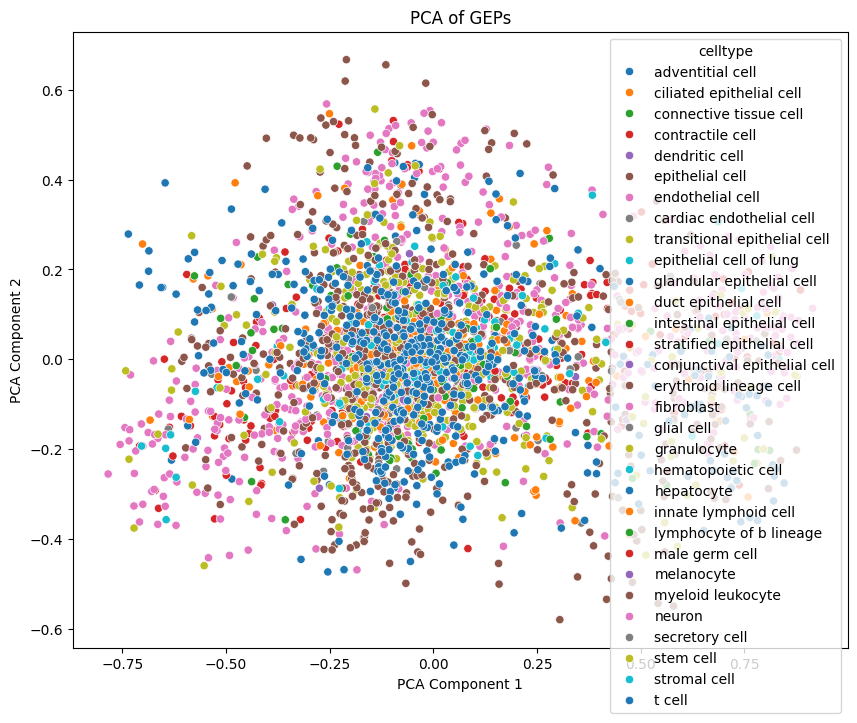

In [32]:
# Perform PCA
pca = PCA(n_components=2)
gep_pca_result = pca.fit_transform(gep_df.T)

# Create a DataFrame for visualization
gep_pca_df = pd.DataFrame(gep_pca_result, columns=['PCA1', 'PCA2'], index=gep_df.columns)
gep_pca_df['celltype'] = gep_pca_df.index.str.split('-').str[-1].str.split('_').str[0]
gep_pca_df['donor'] = gep_pca_df.index.str.split('-').str[-3]
gep_pca_df['tissue'] = gep_pca_df.index.str.split('-').str[-2]

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=gep_pca_df, x='PCA1', y='PCA2', hue='celltype', palette='tab10')
plt.title("PCA of GEPs")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Cluster GEPs

GEPs are clustered using spectral clustering to identify major classes of GEPs across celltypes, tissues and donors. To achieve this, an adjacency matrix is built based on similarity of the top 10 upregulated and top 10 downregulated genes associated with each GEP. 

In [33]:
# Initialize a dictionary to store the indices
top_bottom_indices = {'column': [], 'top10_indices': [], 'bottom10_indices': []}

# Iterate over each column in gep_df
for column in gep_df.columns:
    # Get the top 10 and bottom 10 indices
    top10_indices = gep_df[column].nlargest(10).index.tolist()
    bottom10_indices = gep_df[column].nsmallest(10).index.tolist()
    
    # Append the results to the dictionary
    top_bottom_indices['column'].append(column)
    top_bottom_indices['top10_indices'].append(top10_indices)
    top_bottom_indices['bottom10_indices'].append(bottom10_indices)

# Convert the dictionary to a DataFrame
top_bottom_df = pd.DataFrame(top_bottom_indices)
top_bottom_df

,column,top10_indices,bottom10_indices
0,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP..."
1,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J..."
2,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO..."
3,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,..."
4,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M..."
...,...,...,...
3210,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C..."
3211,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM..."
3212,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT..."
3213,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1..."


In [35]:
# Extract donor, tissue, and celltype from the 'column' values
reference_df = top_bottom_df['column'].str.extract(r'gep_(TSP\d+)-([^_]+)-(.+)_')

# Rename the columns for clarity
reference_df.columns = ['donor', 'tissue', 'celltype']

# Add the 'column' values back to the reference DataFrame
reference_df['column'] = top_bottom_df['column']

# Set 'column' as the index for easy lookup
reference_df.set_index('column', inplace=True)

# Display the reference DataFrame
reference_df

,donor,tissue,celltype
column,,,
gep_TSP14-Lung-adventitial cell_0,TSP14,Lung,adventitial cell
gep_TSP14-Lung-adventitial cell_1,TSP14,Lung,adventitial cell
gep_TSP14-Lung-adventitial cell_2,TSP14,Lung,adventitial cell
gep_TSP14-Lung-adventitial cell_3,TSP14,Lung,adventitial cell
gep_TSP14-Lung-adventitial cell_4,TSP14,Lung,adventitial cell
...,...,...,...
gep_TSP9-Pancreas-t cell_0,TSP9,Pancreas,t cell
gep_TSP9-Pancreas-t cell_1,TSP9,Pancreas,t cell
gep_TSP9-Pancreas-t cell_2,TSP9,Pancreas,t cell


In [36]:
# Initialize the adjacency matrix
adjacency_matrix = np.zeros((len(top_bottom_df), len(top_bottom_df)))

# Iterate over each pair of columns to compute the overlap score
for i in range(len(top_bottom_df)):
    for j in range(len(top_bottom_df)):
        if i != j:
            top_overlap = len(set(top_bottom_df.iloc[i]['top10_indices']).intersection(set(top_bottom_df.iloc[j]['top10_indices'])))
            bottom_overlap = len(set(top_bottom_df.iloc[i]['bottom10_indices']).intersection(set(top_bottom_df.iloc[j]['bottom10_indices'])))
            adjacency_matrix[i, j] = top_overlap + bottom_overlap

# Convert the adjacency matrix to a DataFrame for better readability
adjacency_df = pd.DataFrame(adjacency_matrix, index=top_bottom_df['column'], columns=top_bottom_df['column'])

# Display the adjacency matrix
adjacency_df

column,gep_TSP14-Lung-adventitial cell_0,gep_TSP14-Lung-adventitial cell_1,gep_TSP14-Lung-adventitial cell_2,gep_TSP14-Lung-adventitial cell_3,gep_TSP14-Lung-adventitial cell_4,gep_TSP14-Salivary-Gland-adventitial cell_0,gep_TSP14-Salivary-Gland-adventitial cell_1,gep_TSP14-Salivary-Gland-adventitial cell_2,gep_TSP14-Salivary-Gland-adventitial cell_3,gep_TSP14-Salivary-Gland-adventitial cell_4,...,gep_TSP8-Prostate-t cell_0,gep_TSP8-Prostate-t cell_1,gep_TSP8-Prostate-t cell_2,gep_TSP8-Prostate-t cell_3,gep_TSP8-Prostate-t cell_4,gep_TSP9-Pancreas-t cell_0,gep_TSP9-Pancreas-t cell_1,gep_TSP9-Pancreas-t cell_2,gep_TSP9-Pancreas-t cell_3,gep_TSP9-Pancreas-t cell_4
column,,,,,,,,,,,,,,,,,,,,,
gep_TSP14-Lung-adventitial cell_0,0.0,4.0,3.0,3.0,3.0,4.0,0.0,2.0,0.0,1.0,...,0.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
gep_TSP14-Lung-adventitial cell_1,4.0,0.0,4.0,4.0,5.0,4.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0
gep_TSP14-Lung-adventitial cell_2,3.0,4.0,0.0,6.0,7.0,5.0,2.0,0.0,2.0,0.0,...,1.0,4.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0
gep_TSP14-Lung-adventitial cell_3,3.0,4.0,6.0,0.0,7.0,1.0,2.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
gep_TSP14-Lung-adventitial cell_4,3.0,5.0,7.0,7.0,0.0,4.0,1.0,2.0,2.0,1.0,...,1.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gep_TSP9-Pancreas-t cell_0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,...,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
gep_TSP9-Pancreas-t cell_1,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,0.0,...,3.0,1.0,4.0,5.0,3.0,0.0,0.0,6.0,2.0,5.0
gep_TSP9-Pancreas-t cell_2,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,...,3.0,0.0,4.0,3.0,3.0,0.0,6.0,0.0,2.0,6.0


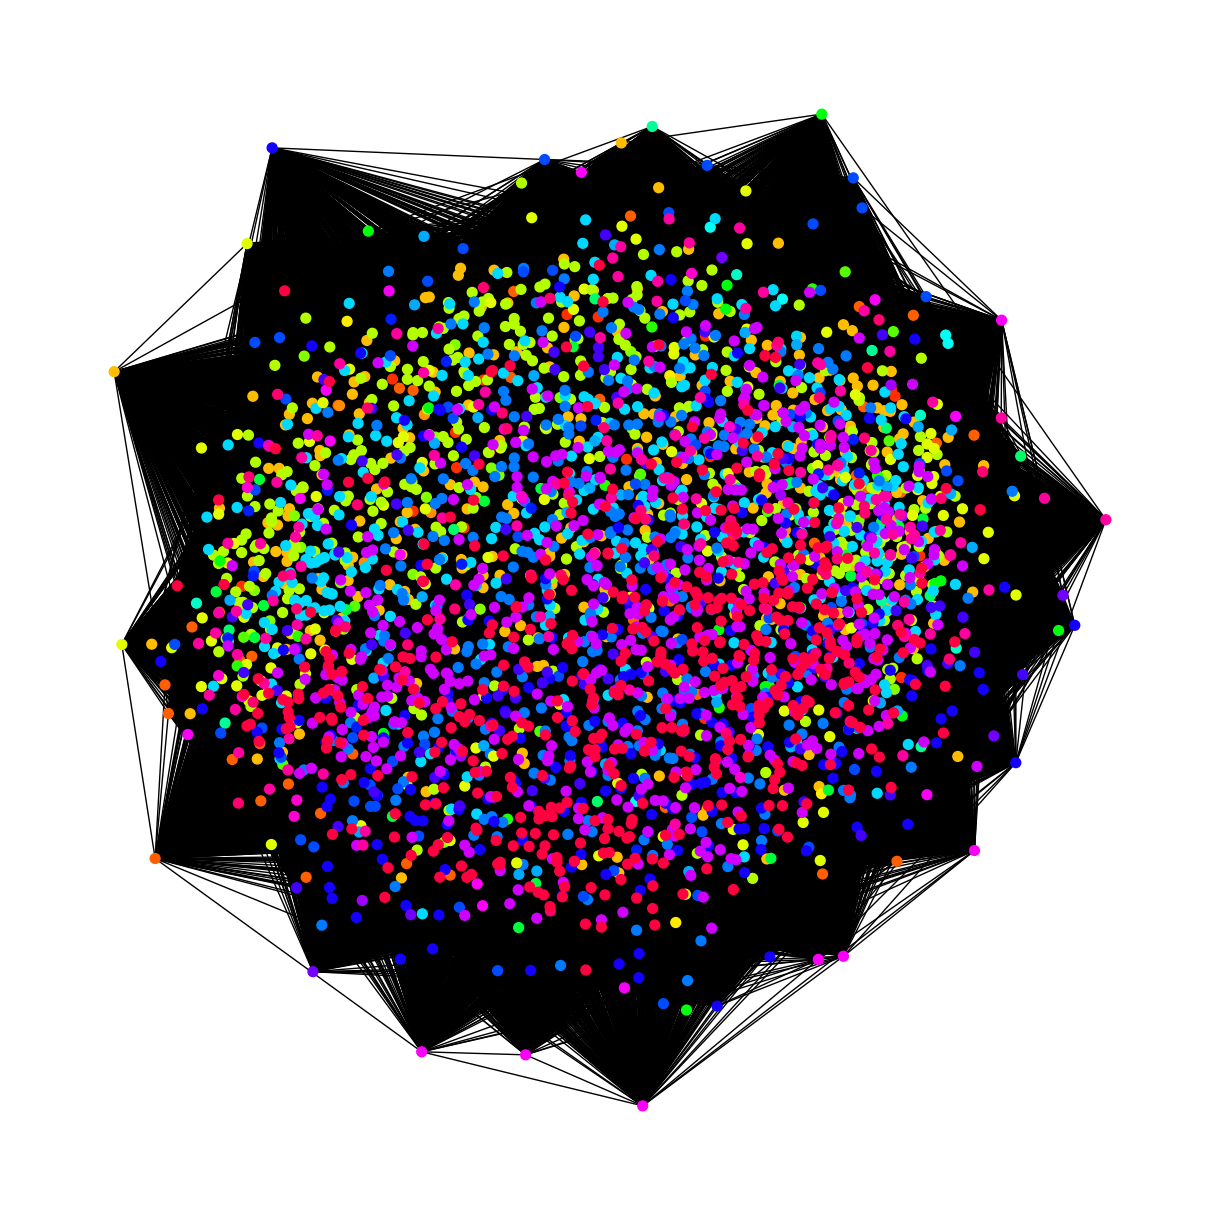

In [39]:
# Create a graph from the adjacency matrix
G = nx.from_pandas_adjacency(adjacency_df)

# Get unique cell types and assign a color to each
cell_types = reference_df['celltype'].unique()
color_map = dict(zip(cell_types, sns.color_palette("hsv", len(cell_types))))

# Assign colors to nodes based on cell type
node_colors = [color_map[reference_df.loc[node, 'celltype']] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)  # positions for all nodes
nx.draw(G, pos, node_size=50, node_color=node_colors)
plt.show()

/tmp/ipykernel_1274252/2661875848.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', bbox_to_anchor=(1.05, 1))


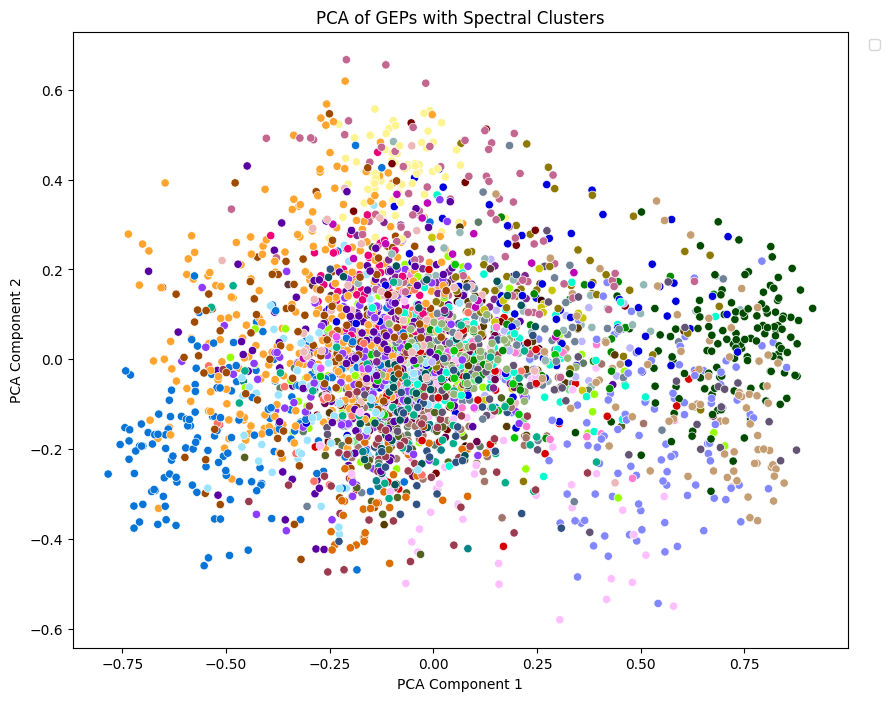

In [85]:
n_clusters = 50

# Perform spectral clustering
spectral = SpectralClustering(affinity='precomputed', n_clusters=n_clusters, random_state=42)
cluster_labels = spectral.fit_predict(adjacency_matrix)

# Add the cluster labels to the gep_pca_df DataFrame for visualization
gep_pca_df['spectral_cluster'] = cluster_labels

# Plot PCA results with spectral cluster labels
plt.figure(figsize=(10, 8))
palette = sns.color_palette(cc.glasbey, n_clusters)
sns.scatterplot(data=gep_pca_df, x='PCA1', y='PCA2', hue='spectral_cluster', palette=palette, legend=False)
plt.title("PCA of GEPs with Spectral Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [3]:
df = pd.merge(reference_df, top_bottom_df, how='inner', left_index=True, right_on='column')
columns_to_take = ['spectral_cluster']
df = pd.merge(df, gep_pca_df['spectral_cluster'], how='inner', left_on='column', right_index=True)
df

,donor,tissue,celltype,column,top10_indices,bottom10_indices,spectral_cluster
0,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP...",47
1,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J...",18
2,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO...",7
3,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,...",2
4,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M...",28
...,...,...,...,...,...,...,...
3210,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C...",28
3211,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM...",43
3212,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT...",43
3213,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1...",28


## Get more broad cell classes

change to anndict env

In [1]:
import dill
import anndict as adt
from dotenv import load_dotenv
import os
import pickle
import pandas as pd
from anndata import read_h5ad

load_dotenv()

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')

adt.configure_llm_backend(provider='anthropic',
                          model='claude-3-5-sonnet-20240620',
                          api_key=ANTHROPIC_API_KEY,
                          requests_per_minute=500
                          )

In [2]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
adata_tf

AnnData object with n_obs × n_vars = 1093048 × 1637
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leiden', 'log1p', 'method_colors

In [3]:
label_hierarchy = adt.create_label_hierarchy(adata=adata_tf, col='broad_cell_class', simplification_levels=['cell type level', 'cell class level'])
label_hierarchy

/hpc/mydata/anton.thieme/projects/TabulaSapiens/src/anndictionary/anndict/ai.py:177: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(
/hpc/mydata/anton.thieme/projects/TabulaSapiens/src/anndictionary/anndict/ai.py:505: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  response = llm(langchain_messages, **kwargs)


{'broad_cell_class_cell_type_level': {'myeloid leukocyte': 'Immune Cell',
  'stem cell': 'Stem Cell',
  'granulocyte': 'Immune Cell',
  'fibroblast': 'Fibroblast',
  't cell': 'T Cell',
  'contractile cell': 'Muscle Cell',
  'endothelial cell': 'Endothelial Cell',
  'erythroid lineage cell': 'Red Blood Cell',
  'innate lymphoid cell': 'Immune Cell',
  'lymphocyte of b lineage': 'B Cell',
  'endo-epithelial cell': 'Epithelial Cell',
  'meso-epithelial cell': 'Epithelial Cell',
  'ciliated epithelial cell': 'Epithelial Cell',
  'secretory cell': 'Secretory Cell',
  'epithelial cell': 'Epithelial Cell',
  'hematopoietic cell': 'Hematopoietic Cell',
  'intestinal epithelial cell': 'Epithelial Cell',
  'glandular epithelial cell': 'Epithelial Cell',
  'transitional epithelial cell': 'Epithelial Cell',
  'dendritic cell': 'Immune Cell',
  'cardiac endothelial cell': 'Endothelial Cell',
  'stromal cell': 'Stromal Cell',
  'glial cell': 'Glial Cell',
  'duct epithelial cell': 'Epithelial Cell'

In [4]:
with open('./sessions/002-cnmf_dtc-major_cell_classes.pkl', 'wb') as f:
    pickle.dump(label_hierarchy, f)

## Investigate Contributions to clusters

Looking at the contributions of celltypes, tissues and donors to each GEP cluster helps in checking if clusters represent major GEPs found across all entities or more specific programs.

change back to cnmf env

In [3]:
with open('./sessions/002-cnmf_dtc-major_cell_classes.pkl', 'rb') as f:
    label_hierarchy = pickle.load(f)

major_cell_classes = label_hierarchy['broad_cell_class_cell_type_level']

"""
major_cell_classes = {
    'adventitial cell': 'fibroblast',
    'cardiac endothelial cell': 'endothelial cell',
    'ciliated epithelial cell': 'epithelial cell',
    'conjunctival epithelial cell': 'epithelial cell',
    'connective tissue cell': 'connective tissue cell',
    'contractile cell': 'contractile cell',
    'dendritic cell': 'leukocyte',
    'duct epithelial cell': 'epithelial cell',
    'ecto-epithelial cell': 'epithelial cell',
    'endo-epithelial cell': 'epithelial cell',
    'endothelial cell': 'endothelial cell',
    'epithelial cell': 'epithelial cell',
    'epithelial cell of lung': 'epithelial cell',
    'erythroid lineage cell': 'erythroid lineage cell',
    'female germ cell': 'germ cell',
    'fibroblast': 'fibroblast',
    'glandular epithelial cell': 'epithelial cell',
    'glial cell': 'glial cell',
    'granulocyte': 'leukocyte',
    'hematopoietic cell': 'leukocyte',
    'hepatocyte': 'hepatocyte',
    'innate lymphoid cell': 'leukocyte',
    'intestinal epithelial cell': 'epithelial cell',
    'kidney epithelial cell': 'epithelial cell',
    'lymphocyte of b lineage': 'leukocyte',
    'male germ cell': 'germ cell',
    'melanocyte': 'melanocyte',
    'meso-epithelial cell': 'epithelial cell',
    'myeloid leukocyte': 'leukocyte',
    'neuron': 'neuron',
    'retinal pigment epithelial cell': 'epithelial cell',
    'secretory cell': 'secretory cell',
    'stem cell': 'stem cell',
    'stratified epithelial cell': 'epithelial cell',
    'stromal cell': 'connective tissue cell',
    't cell': 'leukocyte',
    'transitional epithelial cell': 'epithelial cell',
    'vestibular dark cell': 'epithelial cell',
}
"""

df['major_celltype'] = df['celltype'].map(major_cell_classes)

set(major_cell_classes.values())

{'B Cell',
 'Connective Tissue Cell',
 'Endothelial Cell',
 'Epithelial Cell',
 'Fibroblast',
 'Germ Cell',
 'Glial Cell',
 'Hematopoietic Cell',
 'Hepatocyte',
 'Immune Cell',
 'Melanocyte',
 'Muscle Cell',
 'Neuron',
 'Red Blood Cell',
 'Secretory Cell',
 'Stem Cell',
 'Stromal Cell',
 'T Cell'}

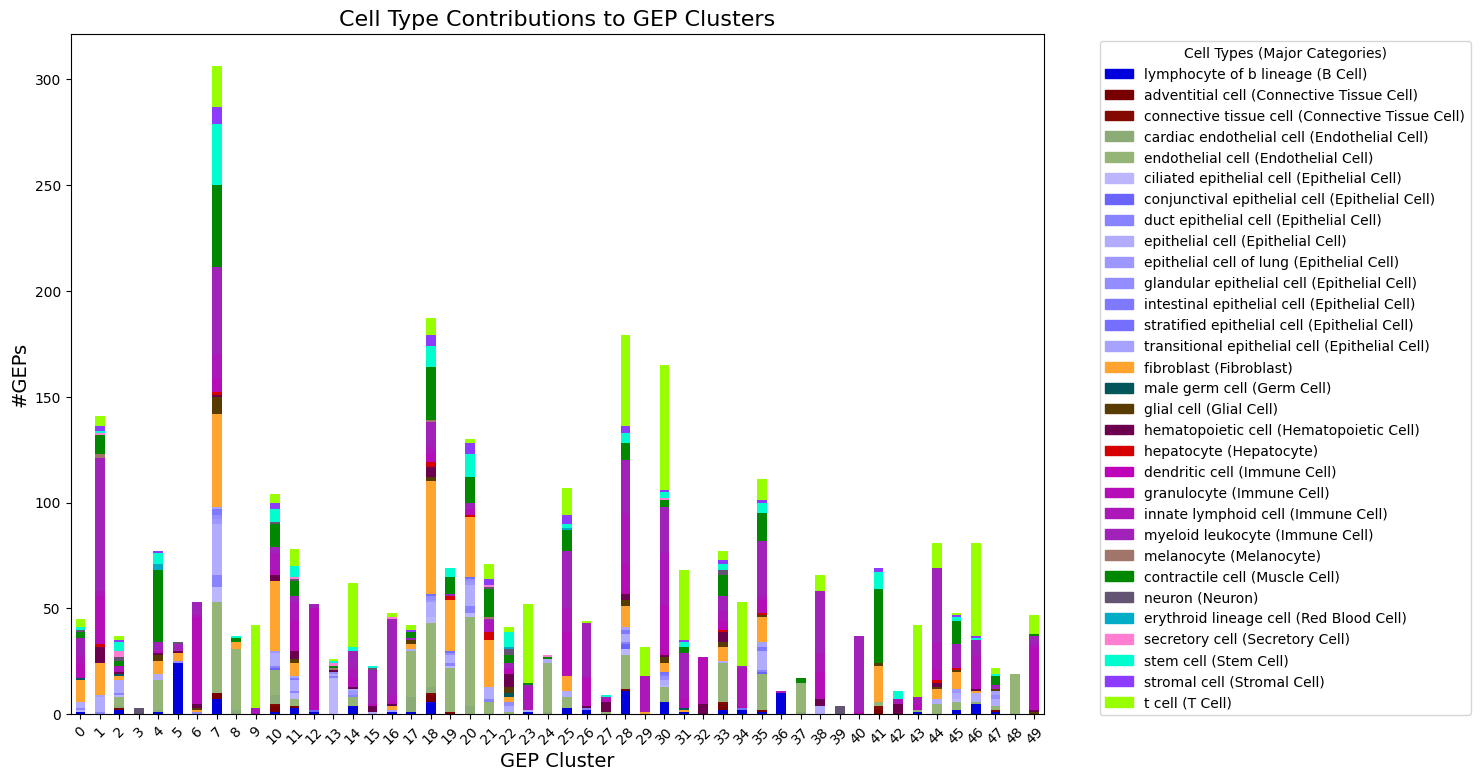

In [7]:
# Assign a unique base color to each major cell class using colorcet's glasbey palette
base_colors = cc.glasbey[:len(set(major_cell_classes.values()))]
major_class_colors = dict(zip(set(major_cell_classes.values()), base_colors))

# Function to generate lighter/darker shades of a base color
def generate_shades(base_color, num_shades, factor=0.04):
    """Generate different shades of a base color."""
    rgba = mcolors.to_rgba(base_color)
    new_rgba = []
    for i in range(num_shades):
        tmp = list(rgba)
        for ii in range(2):
            if rgba[ii] > 0.5:
                tmp[ii] = max(0, rgba[ii] - (i * factor))  # Ensure values don't go negative
            else:
                tmp[ii] = min(1, rgba[ii] + (i * factor))  # Ensure values don't exceed 1
        new_rgba.append(tuple(tmp))
    new_hex = [mcolors.to_hex(new_rgba[i]) for i in range(num_shades)]
    return new_hex

# Generate colors for each cell type based on their major category
celltype_colors = {}

# Iterate through each major cell class and assign shades to its cell types
for major_class, base_color in major_class_colors.items():
    # Find all cell types belonging to this major class
    celltypes_in_class = [ct for ct in df['celltype'].unique() if major_cell_classes.get(ct) == major_class]
    
    # Generate color shades for the cell types in this major class
    shades = generate_shades(base_color, len(celltypes_in_class))
    
    # Assign the generated shades to each cell type
    for ct, shade in zip(celltypes_in_class, shades):
        celltype_colors[ct] = shade

# Handle any cell types not assigned to a major category
default_color = '#d3d3d3'  # Light gray for undefined cell types
for ct in df['celltype'].unique():
    celltype_colors.setdefault(ct, default_color)

# Group by spectral_cluster and celltype, and then sort by major category
cluster_celltype_counts = df.groupby(['spectral_cluster', 'celltype']).size().unstack(fill_value=0)

# Reorder columns based on major categories
ordered_celltypes = sorted(cluster_celltype_counts.columns, key=lambda x: major_cell_classes.get(x, 'Uncategorized'))
cluster_celltype_counts = cluster_celltype_counts[ordered_celltypes]  # Ensure stacked bars follow this order

# Group cell types by their major categories for the legend
grouped_celltypes = defaultdict(list)
for ct in ordered_celltypes:
    major_class = major_cell_classes.get(ct, 'Uncategorized')
    grouped_celltypes[major_class].append(ct)

# Build custom legend entries (aligned with ordered_celltypes)
legend_patches = [
    mpatches.Patch(color=celltype_colors[ct], label=f"{ct} ({major_class})")
    for major_class, celltypes in grouped_celltypes.items()
    for ct in celltypes
]

# Plotting the stacked bar plot
plt.figure(figsize=(15, 8))
cluster_celltype_counts.plot(
    kind='bar',
    stacked=True,
    color=[celltype_colors[ct] for ct in ordered_celltypes],  # Use the same order as the legend
    ax=plt.gca()
)

# Customize plot appearance
plt.title('Cell Type Contributions to GEP Clusters', fontsize=16)
plt.xlabel('GEP Cluster', fontsize=14)
plt.ylabel('#GEPs', fontsize=14)
plt.xticks(rotation=45)

# Add the custom legend with grouped cell types
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='best', title='Cell Types (Major Categories)', fontsize=10)

plt.tight_layout()
plt.show()

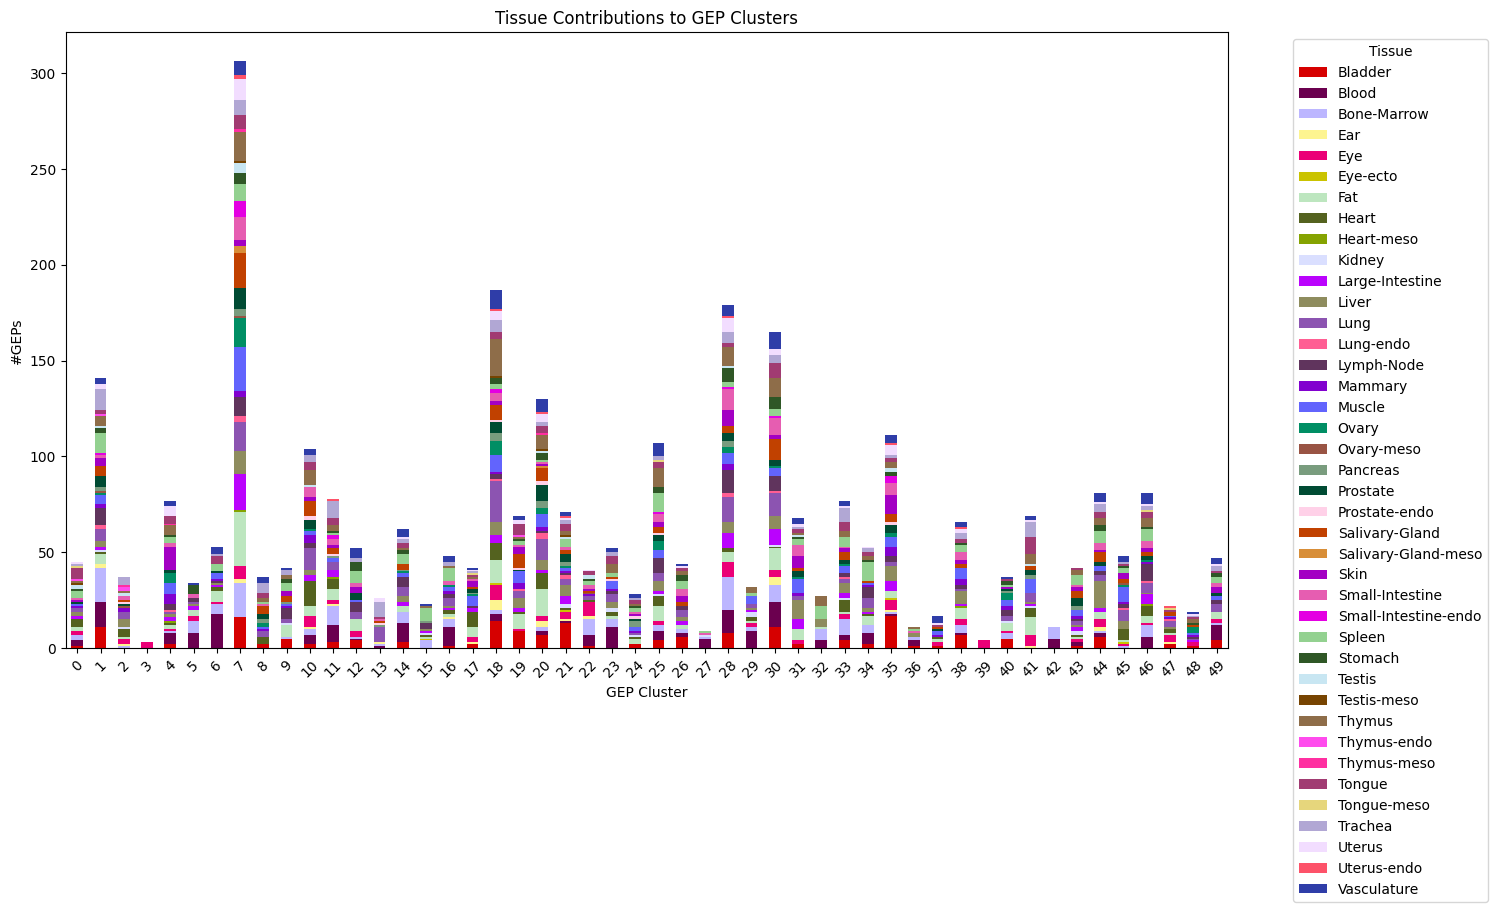

In [5]:
# Get unique spectral clusters
spectral_clusters = df['spectral_cluster'].unique()

# Create a DataFrame to store the counts of each cell type in each cluster
cluster_celltype_counts = df.groupby(['spectral_cluster', 'tissue']).size().unstack(fill_value=0)

# Plot the stacked bar plot
plt.figure(figsize=(15, 8))
cmap = ListedColormap(cc.glasbey, len(spectral_clusters))
cluster_celltype_counts.plot(kind='bar', stacked=True, colormap=cmap, ax=plt.gca())
plt.title('Tissue Contributions to GEP Clusters')
plt.xlabel('GEP Cluster')
plt.ylabel('#GEPs')
plt.xticks(rotation=45)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Tissue')
plt.show()

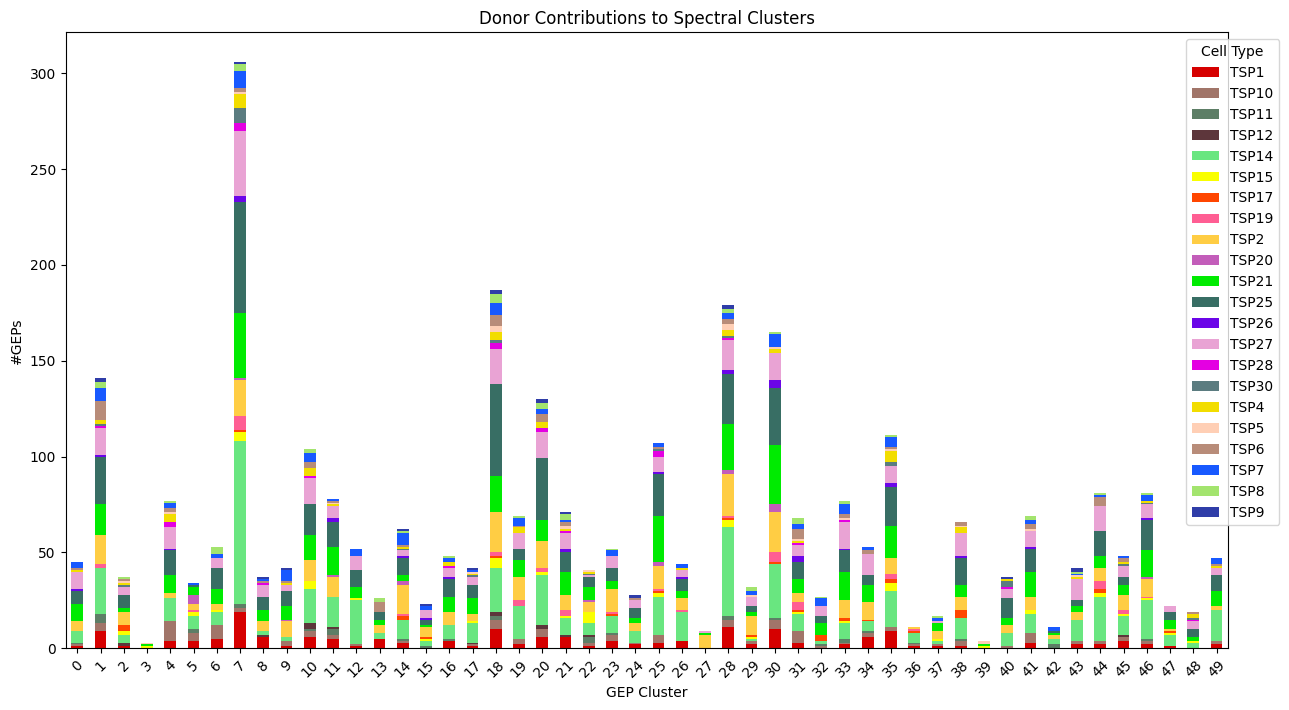

In [6]:
# Get unique spectral clusters
spectral_clusters = df['spectral_cluster'].unique()

# Create a DataFrame to store the counts of each cell type in each cluster
cluster_celltype_counts = df.groupby(['spectral_cluster', 'donor']).size().unstack(fill_value=0)

# Plot the stacked bar plot
plt.figure(figsize=(15, 8))
cmap = ListedColormap(cc.glasbey, len(spectral_clusters))
cluster_celltype_counts.plot(kind='bar', stacked=True, colormap=cmap, ax=plt.gca())
plt.title('Donor Contributions to Spectral Clusters')
plt.xlabel('GEP Cluster')
plt.ylabel('#GEPs')
plt.xticks(rotation=45)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Cell Type')
plt.show()

## Annotate clusters

In order to investigate the biological meaning of each GEP cluster, they are annotated based on the top 10 genes that are most commonly found in the top 10 upregulated genes of GEPs that are part of the cluster and the top 10 genes that are most commonly found in the top 10 downregulated genes of GEPs that are part of the cluster.

A modified version of the anndictionary annotation functionality is used to take both the upregulated and downregulated genes into account.

In [7]:
genes = {}

for cluster in range(len(df['spectral_cluster'].unique())):
    top_genes = []
    bottom_genes = []
    
    for indices in df[df['spectral_cluster'] == cluster]['top10_indices']:
        top_genes.extend(indices)
    
    for indices in df[df['spectral_cluster'] == cluster]['bottom10_indices']:
        bottom_genes.extend(indices)
    
    top_gene_counts = dict(Counter(top_genes))
    bottom_gene_counts = dict(Counter(bottom_genes))
    
    print(f"Cluster size: {len(df[df['spectral_cluster'] == cluster])}")
    print(f"Cluster {cluster} - Top Genes: {Counter(top_genes)}")
    print(f"Cluster {cluster} - Bottom Genes: {Counter(bottom_genes)}")

    genes[cluster] = {'top': top_gene_counts, 'bottom': bottom_gene_counts}


Cluster size: 45
Cluster 0 - Top Genes: Counter({'EBF1': 10, 'NFIB': 7, 'FOS': 6, 'KLF2': 6, 'MEIS1': 6, 'CEBPD': 5, 'NR4A1': 5, 'TBX18': 5, 'KLF9': 5, 'ZBTB7C': 5, 'YBX1': 5, 'ZBTB16': 5, 'ATF3': 5, 'EPAS1': 5, 'TCF4': 5, 'JUN': 4, 'EGR1': 4, 'NR4A2': 4, 'ZFHX3': 4, 'ZFPM2': 4, 'JUND': 3, 'JUNB': 3, 'CEBPB': 3, 'ELF3': 3, 'EGR3': 3, 'ZBTB10': 3, 'SETDB2': 3, 'CREM': 3, 'ZNF385B': 3, 'BNC2': 3, 'HIF3A': 3, 'TCF7L1': 3, 'RUNX2': 3, 'ARID5B': 3, 'YBX3': 2, 'SOX5': 2, 'CUX2': 2, 'SMAD3': 2, 'ZNF90': 2, 'GLI3': 2, 'SETBP1': 2, 'NR2F2': 2, 'GATA6': 2, 'AEBP1': 2, 'NFIA': 2, 'TWIST2': 2, 'PRRX1': 2, 'ESR1': 2, 'DACH1': 2, 'TEAD1': 2, 'KLF6': 2, 'KLF4': 2, 'SKIL': 2, 'EBF2': 2, 'TSC22D1': 2, 'NFATC1': 2, 'FOXP2': 2, 'MEF2C': 2, 'NFKB1': 2, 'SMAD4': 2, 'JDP2': 2, 'FOXN2': 2, 'GLIS2': 2, 'BACH2': 2, 'NPAS3': 2, 'ZNF827': 2, 'PRMT3': 2, 'NR4A3': 2, 'ZNF215': 2, 'CXXC5': 2, 'PRDM1': 2, 'MBNL2': 2, 'KLF8': 2, 'RORB': 1, 'FOSL2': 1, 'HEYL': 1, 'ETV5': 1, 'ETS2': 1, 'ZNF675': 1, 'CSRNP2': 1, 'ZNF493

In [3]:
# Save the genes dictionary to a file for use in downstream analysis with different environment
with open('./sessions/002-cnmf_dtc-genes.pkl', 'wb') as f:
    pickle.dump(genes, f)

change to anndict environment

In [6]:
import dill
import anndict as adt
from dotenv import load_dotenv
import os
import pickle
import pandas as pd

load_dotenv()

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')

In [2]:
with open('./sessions/002-cnmf_dtc-genes.pkl', 'rb') as f:
    genes = pickle.load(f)

for cluster in genes.keys():
    genes[cluster]['top'] = dict(sorted(genes[cluster]['top'].items(), key=lambda item: item[1], reverse=True))
    genes[cluster]['bottom'] = dict(sorted(genes[cluster]['bottom'].items(), key=lambda item: item[1], reverse=True))

genes

{0: {'top': {'EBF1': 10,
   'NFIB': 7,
   'FOS': 6,
   'KLF2': 6,
   'MEIS1': 6,
   'CEBPD': 5,
   'NR4A1': 5,
   'TBX18': 5,
   'KLF9': 5,
   'ZBTB7C': 5,
   'YBX1': 5,
   'ZBTB16': 5,
   'ATF3': 5,
   'EPAS1': 5,
   'TCF4': 5,
   'JUN': 4,
   'EGR1': 4,
   'NR4A2': 4,
   'ZFHX3': 4,
   'ZFPM2': 4,
   'JUND': 3,
   'JUNB': 3,
   'CEBPB': 3,
   'ELF3': 3,
   'EGR3': 3,
   'ZBTB10': 3,
   'SETDB2': 3,
   'CREM': 3,
   'ZNF385B': 3,
   'BNC2': 3,
   'HIF3A': 3,
   'TCF7L1': 3,
   'RUNX2': 3,
   'ARID5B': 3,
   'YBX3': 2,
   'SOX5': 2,
   'CUX2': 2,
   'SMAD3': 2,
   'ZNF90': 2,
   'GLI3': 2,
   'SETBP1': 2,
   'NR2F2': 2,
   'GATA6': 2,
   'AEBP1': 2,
   'NFIA': 2,
   'TWIST2': 2,
   'PRRX1': 2,
   'ESR1': 2,
   'DACH1': 2,
   'TEAD1': 2,
   'KLF6': 2,
   'KLF4': 2,
   'SKIL': 2,
   'EBF2': 2,
   'TSC22D1': 2,
   'NFATC1': 2,
   'FOXP2': 2,
   'MEF2C': 2,
   'NFKB1': 2,
   'SMAD4': 2,
   'JDP2': 2,
   'FOXN2': 2,
   'GLIS2': 2,
   'BACH2': 2,
   'NPAS3': 2,
   'ZNF827': 2,
   'PRMT3': 2,

In [3]:
adt.configure_llm_backend(provider='anthropic',
                          model='claude-3-5-sonnet-20240620',
                          api_key=ANTHROPIC_API_KEY,
                          requests_per_minute=500
                          )

In [4]:
#Biological inference functions
def ai_biological_process(gene_list_top, gene_list_bottom):
    """
    Describes the most prominent biological process represented by a list of genes using the AI.

    Args:
        gene_list (list of str): The list of genes to be described.

    Returns:
        dict: A dictionary containing the description of the biological process.
    """
    #enforce that labels are semantic
    adt.enforce_semantic_list(gene_list_top)
    adt.enforce_semantic_list(gene_list_bottom)

    # Prepare the prompt
    genes_str_top = "    ".join(gene_list_top)
    genes_str_bottom = "    ".join(gene_list_bottom)
    base_prompt = f"""In a few words and without restating any part of the question, 
    describe the single most prominent biological process represented by the upregulation of the genes: 
    {genes_str_top}, and the downregulation of the genes: {gene_list_bottom}"""

    # Prepare the messages for the Chat Completions API
    messages = [
        {"role": "system", "content": "You are a terse molecular biologist."},
        {"role": "user", "content": base_prompt}
    ]

    # Call the LLM using the call_llm function
    annotation = adt.call_llm(
        messages=messages,
        max_tokens=200,
        temperature=0
    )

    return annotation

In [8]:
annotation_df = pd.DataFrame(columns=['spectral_cluster', 'annotation'])

for i in range(len(genes.keys())):
    print(f'Cluster {i}')    
    top_genes = list(genes[i]['top'].keys())[:10]
    top_gene_counts = list(genes[i]['top'].values())[:10]
    bottom_genes = list(genes[i]['bottom'].keys())[:10]
    bottom_gene_counts = list(genes[i]['bottom'].values())[:10]
    annotation = ai_biological_process(top_genes, bottom_genes)
    annotation_df.loc[i] = {'spectral_cluster': i, 'annotation': annotation}
    print(top_genes)
    print(top_gene_counts)
    print(bottom_genes)
    print(bottom_gene_counts)
    print(annotation)

Cluster 0
['EBF1', 'NFIB', 'FOS', 'KLF2', 'MEIS1', 'CEBPD', 'NR4A1', 'TBX18', 'KLF9', 'ZBTB7C']
[10, 7, 6, 6, 6, 5, 5, 5, 5, 5]
['RUNX1', 'ELF2', 'SMYD3', 'TCF4', 'TRPS1', 'NFKB1', 'RFX3', 'FOXO1', 'TWIST2', 'GLIS3']
[45, 12, 10, 8, 8, 7, 6, 6, 6, 5]
Cellular differentiation and lineage commitment.
Cluster 1
['ZEB1', 'RUNX2', 'MECOM', 'BACH2', 'SPIB', 'ZBTB20', 'NFATC2', 'PBX1', 'ETV6', 'RUNX1']
[21, 20, 15, 15, 15, 15, 14, 13, 12, 12]
['CEBPB', 'JUNB', 'FOS', 'CEBPD', 'FOXO3', 'ZEB2', 'EGR1', 'MAFB', 'KLF2', 'JUND']
[138, 64, 61, 57, 46, 45, 37, 37, 33, 30]
Hematopoietic stem cell self-renewal and differentiation regulation.
Cluster 2
['KLF6', 'CEBPD', 'JUN', 'MAFB', 'NR2F2', 'XBP1', 'HES4', 'GATA2', 'KLF2', 'NFKB1']
[8, 6, 5, 5, 5, 4, 4, 4, 4, 4]
['SMYD3', 'TCF12', 'TSHZ2', 'ZBTB20', 'NFIA', 'FOXP2', 'MEIS1', 'MEIS2', 'ZFPM2', 'MECOM']
[34, 10, 9, 9, 8, 7, 7, 6, 6, 6]
Inflammatory response activation and developmental gene suppression.
Cluster 3
['VSX1', 'ST18', 'ZNF804B', 'ISL1', 'V

In [13]:
pd.set_option('display.max_colwidth', 200)

annotation_df

,spectral_cluster,annotation
0,0,Cellular differentiation and lineage commitment.
1,1,Hematopoietic stem cell self-renewal and differentiation regulation.
2,2,Inflammatory response activation and developmental gene suppression.
3,3,Neuronal differentiation and retinal development inhibition.
4,4,Cellular stress response and transcriptional regulation.
5,5,Plasma cell differentiation from B cells.
6,6,Hematopoietic stem cell differentiation and lineage commitment.
7,7,Immune response activation and inflammation suppression.
8,8,Cardiovascular development and angiogenesis.
9,9,B-cell differentiation and activation


In [14]:
annotation_df.to_csv('../results/cnmf/gep_cluster_annotations.csv', index=False)

# Transfer Annotations to cluster identities

change back to cnmf environment

In [65]:
annotation_df = pd.read_csv('../results/cnmf/gep_cluster_annotations.csv')
df = pd.merge(df, annotation_df, how='inner', left_on='spectral_cluster', right_on='spectral_cluster')
df

,donor,tissue,celltype,column,top10_indices,bottom10_indices,spectral_cluster,major_celltype,annotation
0,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP...",47,fibroblast,Mesenchymal differentiation and epithelial-mes...
1,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J...",18,fibroblast,"Neuronal differentiation and maturation, with ..."
2,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO...",7,fibroblast,Immune response activation and inflammation su...
3,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,...",2,fibroblast,Inflammatory response activation and developme...
4,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M...",28,fibroblast,Epithelial-mesenchymal transition (EMT)
...,...,...,...,...,...,...,...,...,...
3210,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C...",28,leukocyte,Epithelial-mesenchymal transition (EMT)
3211,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM...",43,leukocyte,Neuronal differentiation and maturation.
3212,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT...",43,leukocyte,Neuronal differentiation and maturation.
3213,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1...",28,leukocyte,Epithelial-mesenchymal transition (EMT)


## Reassign Clusters based on annotations

Some clusters have been annotated with the same biological meaning and should be bundled together

In [70]:
unique_annotations = df['annotation'].unique()
df['anno_cluster'] = df['annotation'].map(dict(zip(unique_annotations, range(len(unique_annotations)))))
df

,donor,tissue,celltype,column,top10_indices,bottom10_indices,spectral_cluster,major_celltype,annotation,anno_cluster
0,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP...",47,fibroblast,Mesenchymal differentiation and epithelial-mes...,0
1,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J...",18,fibroblast,"Neuronal differentiation and maturation, with ...",1
2,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO...",7,fibroblast,Immune response activation and inflammation su...,2
3,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,...",2,fibroblast,Inflammatory response activation and developme...,3
4,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M...",28,fibroblast,Epithelial-mesenchymal transition (EMT),4
...,...,...,...,...,...,...,...,...,...,...
3210,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C...",28,leukocyte,Epithelial-mesenchymal transition (EMT),4
3211,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM...",43,leukocyte,Neuronal differentiation and maturation.,27
3212,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT...",43,leukocyte,Neuronal differentiation and maturation.,27
3213,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1...",28,leukocyte,Epithelial-mesenchymal transition (EMT),4


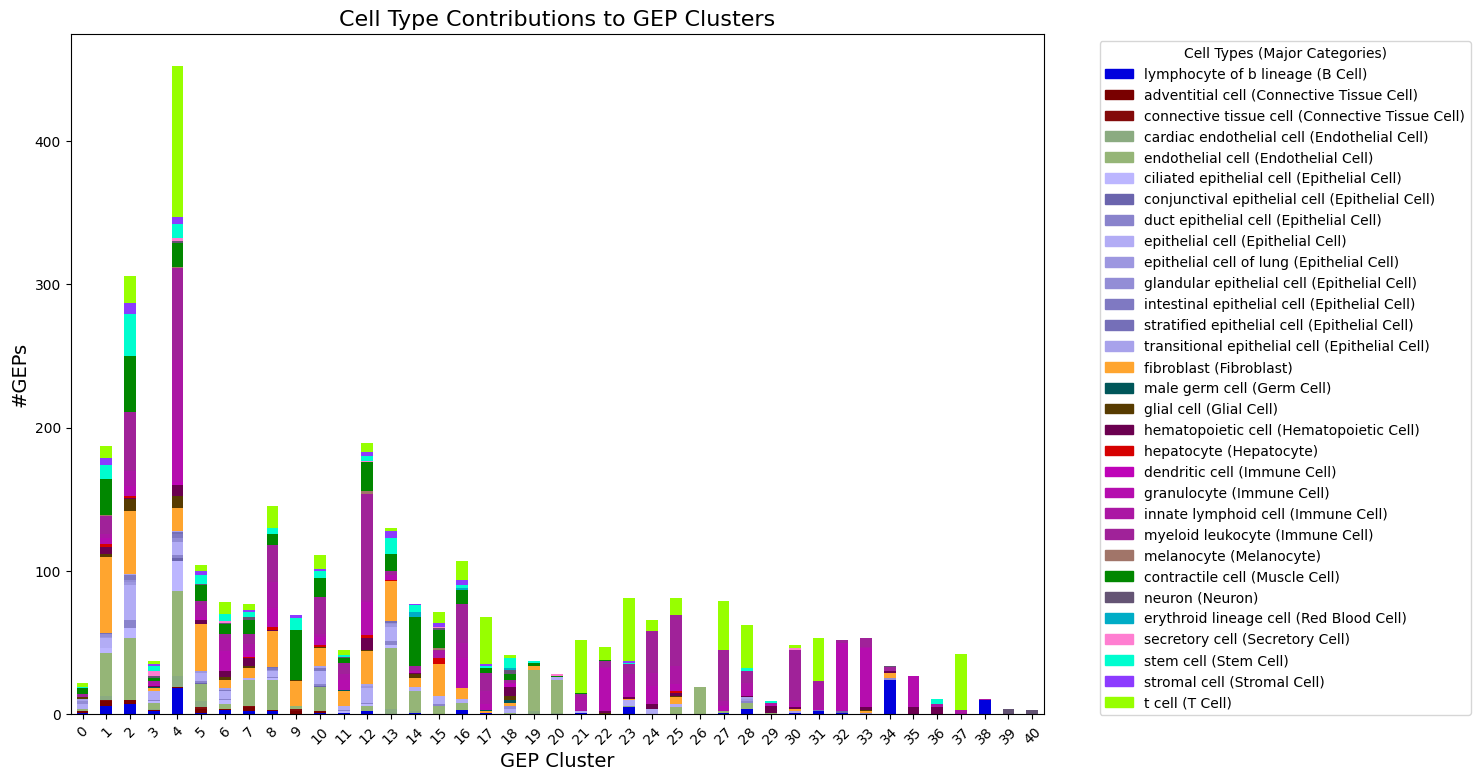

In [8]:
# Assign a unique base color to each major cell class using colorcet's glasbey palette
base_colors = cc.glasbey[:len(set(major_cell_classes.values()))]
major_class_colors = dict(zip(set(major_cell_classes.values()), base_colors))

# Function to generate lighter/darker shades of a base color
def generate_shades(base_color, num_shades, factor=0.04):
    """Generate different shades of a base color."""
    rgba = mcolors.to_rgba(base_color)
    new_rgba = []
    for i in range(num_shades):
        tmp = []
        for ii in range(4):
            if rgba[ii] > 0.5:
                tmp.append(max(0, rgba[ii] - (i * factor)))  # Ensure values don't go negative
            else:
                tmp.append(min(1, rgba[ii] + (i * factor)))  # Ensure values don't exceed 1
        new_rgba.append(tuple(tmp))
    new_hex = [mcolors.to_hex(new_rgba[i]) for i in range(num_shades)]
    return new_hex

# Generate colors for each cell type based on their major category
celltype_colors = {}

# Iterate through each major cell class and assign shades to its cell types
for major_class, base_color in major_class_colors.items():
    # Find all cell types belonging to this major class
    celltypes_in_class = [ct for ct in df['celltype'].unique() if major_cell_classes.get(ct) == major_class]
    
    # Generate color shades for the cell types in this major class
    shades = generate_shades(base_color, len(celltypes_in_class))
    
    # Assign the generated shades to each cell type
    for ct, shade in zip(celltypes_in_class, shades):
        celltype_colors[ct] = shade

# Handle any cell types not assigned to a major category
default_color = '#d3d3d3'  # Light gray for undefined cell types
for ct in df['celltype'].unique():
    celltype_colors.setdefault(ct, default_color)

# Group by anno_cluster and celltype, and then sort by major category
cluster_celltype_counts = df.groupby(['anno_cluster', 'celltype']).size().unstack(fill_value=0)

# Reorder columns based on major categories
ordered_celltypes = sorted(cluster_celltype_counts.columns, key=lambda x: major_cell_classes.get(x, 'Uncategorized'))
cluster_celltype_counts = cluster_celltype_counts[ordered_celltypes]  # Ensure stacked bars follow this order

# Group cell types by their major categories for the legend
grouped_celltypes = defaultdict(list)
for ct in ordered_celltypes:
    major_class = major_cell_classes.get(ct, 'Uncategorized')
    grouped_celltypes[major_class].append(ct)

# Build custom legend entries (aligned with ordered_celltypes)
legend_patches = [
    mpatches.Patch(color=celltype_colors[ct], label=f"{ct} ({major_class})")
    for major_class, celltypes in grouped_celltypes.items()
    for ct in celltypes
]

# Plotting the stacked bar plot
plt.figure(figsize=(15, 8))
cluster_celltype_counts.plot(
    kind='bar',
    stacked=True,
    color=[celltype_colors[ct] for ct in ordered_celltypes],  # Use the same order as the legend
    ax=plt.gca()
)

# Customize plot appearance
plt.title('Cell Type Contributions to GEP Clusters', fontsize=16)
plt.xlabel('GEP Cluster', fontsize=14)
plt.ylabel('#GEPs', fontsize=14)
plt.xticks(rotation=45)

# Add the custom legend with grouped cell types
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='best', title='Cell Types (Major Categories)', fontsize=10)

plt.tight_layout()
plt.show()

In [74]:
for i in range(len(df['anno_cluster'].unique())):
    print(f'Cluster {i}: {df[df["anno_cluster"] == i]["annotation"].values[0]}')

Cluster 0: Mesenchymal differentiation and epithelial-mesenchymal transition.
Cluster 1: Neuronal differentiation and maturation, with suppression of immediate early genes.
Cluster 2: Immune response activation and inflammation suppression.
Cluster 3: Inflammatory response activation and developmental gene suppression.
Cluster 4: Epithelial-mesenchymal transition (EMT)
Cluster 5: Immediate early gene response signaling cascade.
Cluster 6: Cell cycle progression and proliferation, with suppression of differentiation and quiescence.
Cluster 7: Myeloid differentiation and monocyte/macrophage activation.
Cluster 8: T cell differentiation and activation.
Cluster 9: Lymphocyte activation and differentiation, particularly T-cell lineage commitment.
Cluster 10: Immediate early gene response and transcriptional reprogramming associated with cellular stress adaptation.
Cluster 11: Cellular differentiation and lineage commitment.
Cluster 12: Hematopoietic stem cell self-renewal and differentiatio

# Transfer annotations to cells

The annotated GEPs need to be transfered to the cells via the GEP usage information from the cnmf run.

In [67]:
# Initialize storage for GEPs and dataset labels
all_usages = pd.DataFrame(columns=['cell_id', 'gep_id', 'usage', 'dtc'])
dataset_labels_usages = []
error_dtcs_usages = []

# Iterate through cell types and DTC directories
for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for dtc in os.listdir(os.path.join(base_path, run, celltype)):
        print(f'DTC: {dtc}')

        try:
        
            # Load the cNMF object
            with open(os.path.join(base_path, run, celltype, dtc, 'cnmf_obj.pkl'), 'rb') as f:
                cnmf_obj = pickle.load(f)

            # Update paths in cnmf_obj to ensure correct usage
            for key in cnmf_obj.paths.keys():
                path = cnmf_obj.paths[key]
                cnmf_obj.paths[key] = path[3:]  # Remove leading '../'

            # Generate consensus matrix and load results
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning) 
                cnmf_obj.consensus(k=selected_k, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=True)
                results = cnmf_obj.load_results(K=selected_k, density_threshold=density_threshold, n_top_genes=10)

            usages = results[0]
            print(f'usages.shape: {usages.shape}')
            usages_tmp = usages.melt(ignore_index=False).reset_index()
            usages_tmp.columns = ['cell_id', 'gep_id', 'usage']
            usages_tmp['gep_id'] = 'gep_' + dtc + '_' + (usages_tmp['gep_id']-1).astype(str)
            usages_tmp['dtc'] = dtc
            all_usages = pd.concat([all_usages, usages_tmp], ignore_index=True)  # Concatenate usages
            
            dataset_labels_usages.extend([f'{celltype}_{dtc}'] * geps_norm.shape[1])  # Label programs by dataset

        except Exception as e:
            print(f'Error processing {dtc}: {e}')
            error_dtcs_usages.append(dtc)

print(f'Successfully retrieved GEPs for {len(all_usages['dtc'].unique())} datasets.')
print(f'Failed to retrieve GEPs for {len(error_dtcs_usages)} datasets.')

Celltype: adventitial cell
DTC: TSP14-Lung-adventitial cell
usages.shape: (84, 5)
DTC: TSP14-Salivary-Gland-adventitial cell


/tmp/ipykernel_2367387/3873641034.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_usages = pd.concat([all_usages, usages_tmp], ignore_index=True)  # Concatenate usages


usages.shape: (106, 5)
DTC: TSP25-Lung-adventitial cell
usages.shape: (141, 5)
DTC: TSP7-Salivary-Gland-adventitial cell
usages.shape: (215, 5)
Celltype: ciliated epithelial cell
DTC: TSP1-Lung-ciliated epithelial cell
usages.shape: (295, 5)
DTC: TSP14-Lung-ciliated epithelial cell
usages.shape: (130, 5)
DTC: TSP2-Lung-ciliated epithelial cell
usages.shape: (378, 5)
DTC: TSP2-Trachea-ciliated epithelial cell
usages.shape: (56, 5)
DTC: TSP21-Trachea-ciliated epithelial cell
usages.shape: (91, 5)
DTC: TSP21-Uterus-ciliated epithelial cell
usages.shape: (287, 5)
DTC: TSP25-Lung-ciliated epithelial cell
usages.shape: (282, 5)
DTC: TSP6-Trachea-ciliated epithelial cell
usages.shape: (484, 5)
Celltype: connective tissue cell
DTC: TSP2-Trachea-connective tissue cell
usages.shape: (148, 5)
Celltype: contractile cell
DTC: TSP1-Bladder-contractile cell
usages.shape: (1919, 5)
DTC: TSP1-Lung-contractile cell
usages.shape: (120, 5)
DTC: TSP1-Muscle-contractile cell
usages.shape: (705, 5)
DTC: TSP1

In [10]:
df

,donor,tissue,celltype,column,top10_indices,bottom10_indices,spectral_cluster,major_celltype,annotation,anno_cluster
0,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP...",47,Connective Tissue Cell,Mesenchymal differentiation and epithelial-mes...,0
1,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J...",18,Connective Tissue Cell,"Neuronal differentiation and maturation, with ...",1
2,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO...",7,Connective Tissue Cell,Immune response activation and inflammation su...,2
3,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,...",2,Connective Tissue Cell,Inflammatory response activation and developme...,3
4,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M...",28,Connective Tissue Cell,Epithelial-mesenchymal transition (EMT),4
...,...,...,...,...,...,...,...,...,...,...
3210,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C...",28,T Cell,Epithelial-mesenchymal transition (EMT),4
3211,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM...",43,T Cell,Neuronal differentiation and maturation.,27
3212,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT...",43,T Cell,Neuronal differentiation and maturation.,27
3213,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1...",28,T Cell,Epithelial-mesenchymal transition (EMT),4


In [11]:
all_usages

,cell_id,gep_id,usage,dtc
0,TSP14_Lung_NA_10X_2_1_ACACTGACACAAGTTC,gep_TSP14-Lung-adventitial cell_0,0.195429,TSP14-Lung-adventitial cell
1,TSP14_Lung_NA_10X_2_1_ACTTATCAGGGTCAAC,gep_TSP14-Lung-adventitial cell_0,0.398325,TSP14-Lung-adventitial cell
2,TSP14_Lung_NA_10X_2_1_AGTCACACATCTTCGC,gep_TSP14-Lung-adventitial cell_0,0.171012,TSP14-Lung-adventitial cell
3,TSP14_Lung_NA_10X_2_1_CCACACTCACTCCGGA,gep_TSP14-Lung-adventitial cell_0,0.591497,TSP14-Lung-adventitial cell
4,TSP14_Lung_NA_10X_2_1_CGGAATTAGTGCCAGA,gep_TSP14-Lung-adventitial cell_0,0.000000,TSP14-Lung-adventitial cell
...,...,...,...,...
4064675,TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal_...,gep_TSP9-Pancreas-t cell_4,0.000000,TSP9-Pancreas-t cell
4064676,TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal_...,gep_TSP9-Pancreas-t cell_4,0.000000,TSP9-Pancreas-t cell
4064677,TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal_...,gep_TSP9-Pancreas-t cell_4,0.013151,TSP9-Pancreas-t cell
4064678,TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal_...,gep_TSP9-Pancreas-t cell_4,0.000000,TSP9-Pancreas-t cell


In [ ]:
for i in range(selected_k):
    adata_tf.obs['gep_' + str(i)] = ''
    adata_tf.obs['gep_' + str(i) + '_usage'] = 0.0

for i, row in all_usages.iterrows():
    for ii in range(selected_k):
        adata_tf.obs.loc[row['cell_id'], 'gep_' + str(i)] = df[df['column'] == row['gep_id']]['annotation'].values[0]
        adata_tf.obs.loc[row['cell_id'], 'gep_' + str(i) + '_usage'] = row['usage']

adata_tf.obs

In [ ]:
usages_df = pd.DataFrame(index=gene_names)

for celltype in os.listdir(os.path.join(base_path, run)):
    print(f'Celltype: {celltype}')
    for i, dtc in enumerate(os.listdir(os.path.join(base_path, run, celltype))):
        if not dtc in error_dtcs:
            print(f'DTC: {dtc}')
            genes_tmp = pd.read_csv(os.path.join(base_path, run, celltype, dtc, 'genes.tsv'), sep='\t', header=None)
            genes_tmp.set_index(keys=0, inplace=True)
            genes_tmp.drop(columns=[1], inplace=True)
            print(f'len(genes_tmp): {len(genes_tmp)}')
            dataset_id = int(dataset_labels.index(celltype + '_' + dtc) / 5)
            print(f'dataset_id: {dataset_id}')
            for ii in range(selected_k):
                gep = all_geps[dataset_id][ii]
                print(f'len(gep): {len(gep)}')
                genes_tmp['gep_' + dtc + '_' + str(ii)] = gep

            gep_df = gep_df.join(genes_tmp, how='left')

In [7]:
gep_df

,gep_TSP14-Lung-adventitial cell_0,gep_TSP14-Lung-adventitial cell_1,gep_TSP14-Lung-adventitial cell_2,gep_TSP14-Lung-adventitial cell_3,gep_TSP14-Lung-adventitial cell_4,gep_TSP14-Salivary-Gland-adventitial cell_0,gep_TSP14-Salivary-Gland-adventitial cell_1,gep_TSP14-Salivary-Gland-adventitial cell_2,gep_TSP14-Salivary-Gland-adventitial cell_3,gep_TSP14-Salivary-Gland-adventitial cell_4,...,gep_TSP8-Prostate-t cell_0,gep_TSP8-Prostate-t cell_1,gep_TSP8-Prostate-t cell_2,gep_TSP8-Prostate-t cell_3,gep_TSP8-Prostate-t cell_4,gep_TSP9-Pancreas-t cell_0,gep_TSP9-Pancreas-t cell_1,gep_TSP9-Pancreas-t cell_2,gep_TSP9-Pancreas-t cell_3,gep_TSP9-Pancreas-t cell_4
index,,,,,,,,,,,,,,,,,,,,,
NFYA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ARX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
HOXA11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
MEOX1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
SOX8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCGF2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ZNF670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.017459,-0.007225,-0.006441,-0.003319,-0.007015
ZNF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
df

,donor,tissue,celltype,column,top10_indices,bottom10_indices,spectral_cluster
0,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_0,"[ESR1, NR4A2, RORA, ZNF704, BNC2, FOXP2, BHLHE...","[PRDM5, ZNF565, JUND, MBNL2, PBX1, ETV1, HIVEP...",47
1,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_1,"[PRDM5, ARID5A, ZNF608, MEIS1, TSHZ2, RORA, ZN...","[NR4A2, FOXO3, JUN, JUND, OSR2, SOX4, CEBPD, J...",18
2,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_2,"[HIVEP1, NFKB1, SMAD9, ZNF704, ZNF331, RFX2, N...","[JUND, FOS, CEBPD, JUNB, SMYD3, ESR1, EGR1, SO...",7
3,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_3,"[OSR2, THRB, ZNF565, HOXB3, ZNF267, ZBTB45, ZN...","[JUNB, CEBPD, MBNL2, SOX4, SMYD3, MYC, ZNF704,...",2
4,TSP14,Lung,adventitial cell,gep_TSP14-Lung-adventitial cell_4,"[KDM5B, ZNF608, ZNF496, ZNF264, NFATC2, ZNF565...","[CEBPD, MBNL2, KLF6, JUNB, SMYD3, KLF9, FOS, M...",28
...,...,...,...,...,...,...,...
3210,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_0,"[KLF12, ZEB1, SMYD3, NR3C2, TCF12, ZNF609, HES...","[MECOM, NR5A2, ESRRG, KLF6, CEBPB, PBX1, MEF2C...",28
3211,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_1,"[SPI1, MEF2C, MXD1, JDP2, MAFB, PPARG, ZEB2, B...","[BCL11B, IKZF1, ZBTB20, SCML4, STAT4, ETS1, SM...",43
3212,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_2,"[MECOM, NR5A2, THRB, PBX1, ZNF804B, ZNF704, ME...","[IKZF1, KLF12, BCL11B, FLI1, RUNX2, ETS1, STAT...",43
3213,TSP9,Pancreas,t cell,gep_TSP9-Pancreas-t cell_3,"[DMRT1, ZFP37, ZNF407, ZNF416, ZNF615, LCOR, Z...","[BCL11B, JUND, SCMH1, SCML4, KLF6, MECP2, ASH1...",28


### clustering directly on z-score-spectra

/tmp/ipykernel_4151117/1907912145.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', bbox_to_anchor=(1.05, 1))


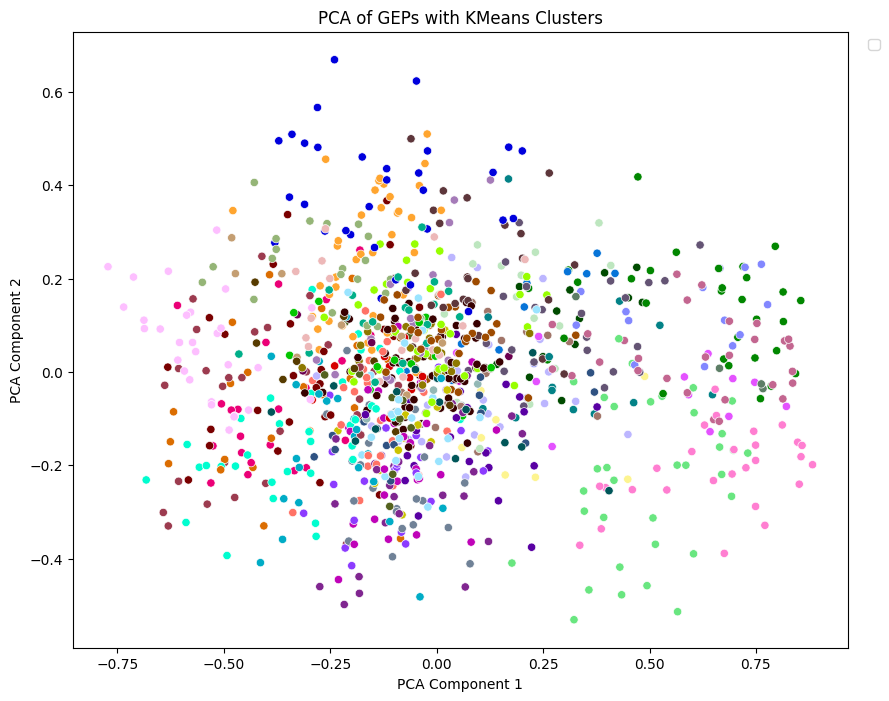

In [4]:
from sklearn.cluster import KMeans

# Assuming gep_df is the sparse matrix
# Perform KMeans clustering
n_clusters = 50  # You can change this number based on your requirement
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(gep_df.T)

# Add the cluster labels to the gep_pca_df DataFrame for visualization
gep_pca_df['cluster'] = clusters

# Plot PCA results with cluster labels
plt.figure(figsize=(10, 8))
palette = sns.color_palette(cc.glasbey, n_clusters)
sns.scatterplot(data=gep_pca_df, x='PCA1', y='PCA2', hue='cluster', palette=palette, legend=False)
plt.title("PCA of GEPs with KMeans Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [5]:
clusters

array([ 2, 26, 22, ..., 49,  5, 38], dtype=int32)

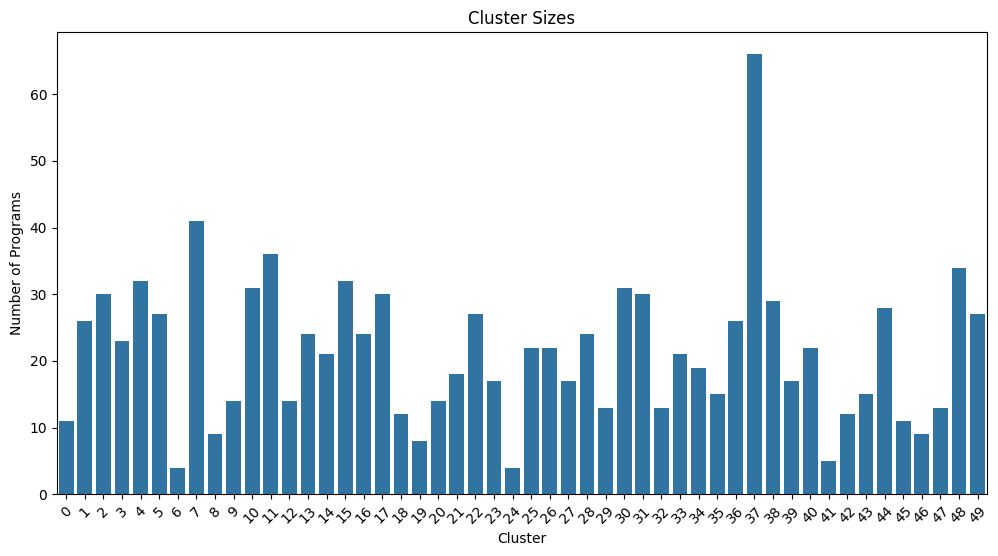

In [6]:
top_10_gene_counts_df = pd.DataFrame(columns=['cluster', 'gene', 'count', 'cluster_size'])

for i_cluster in range(n_clusters):
    column_labels = ['gep_' + '_'.join(lab.split('_')[1:]) + f'_{i%5}' for i, lab in enumerate(dataset_labels)]
    indices = np.where(clusters == i_cluster)[0]
    labels = [column_labels[i] for i in indices]
    gep_cluster_df = gep_df.loc[:, labels]
    cluster_size = len(indices)
    
    sorted_indices = {}

    for column in gep_cluster_df.columns:
        # Filter out zero values and sort by value in descending order
        non_zero_values = gep_cluster_df[column][gep_cluster_df[column] != 0].sort_values(ascending=False)
        # Store the sorted indices
        sorted_indices[column] = non_zero_values.index.tolist()

    top_10_counts = {}
    for column, genes in sorted_indices.items():
        for gene in genes[:10]:  # Only consider the top 10 genes
            if gene not in top_10_counts:
                top_10_counts[gene] = 0
            top_10_counts[gene] += 1

    # Sort the top 10 counts by highest count
    sorted_top_10_counts = dict(sorted(top_10_counts.items(), key=lambda item: item[1], reverse=True))
    sorted_top_10_counts = {k: sorted_top_10_counts[k] for k in list(sorted_top_10_counts)[:10]}

    # Add to the dataframe
    for gene, count in sorted_top_10_counts.items():
        tmp = pd.DataFrame({'cluster': i_cluster, 'gene': gene, 'count': count, 'cluster_size': cluster_size}, index=[0])
        top_10_gene_counts_df = pd.concat([top_10_gene_counts_df, tmp])

# Plot the cluster sizes
cluster_sizes = gep_pca_df['cluster'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Programs')
plt.xticks(rotation=45)
plt.show()

In [7]:
top_10_gene_counts_df['GEPs with gene [%]'] = top_10_gene_counts_df['count'] / top_10_gene_counts_df['cluster_size'] * 100
top_10_gene_counts_df['rank'] = top_10_gene_counts_df.groupby('cluster')['count'].rank(ascending=False, method='first')
top_10_gene_counts_df

,cluster,gene,count,cluster_size,GEPs with gene [%],rank
0,0,MYB,5,11,45.454545,1.0
0,0,SCMH1,5,11,45.454545,2.0
0,0,E2F8,5,11,45.454545,3.0
0,0,TCF4,4,11,36.363636,4.0
0,0,MYBL2,4,11,36.363636,5.0
...,...,...,...,...,...,...
0,49,PBX1,6,27,22.222222,6.0
0,49,EBF2,5,27,18.518519,7.0
0,49,SOX6,5,27,18.518519,8.0
0,49,ZNF385B,5,27,18.518519,9.0


<Axes: xlabel='rank', ylabel='GEPs with gene [%]'>

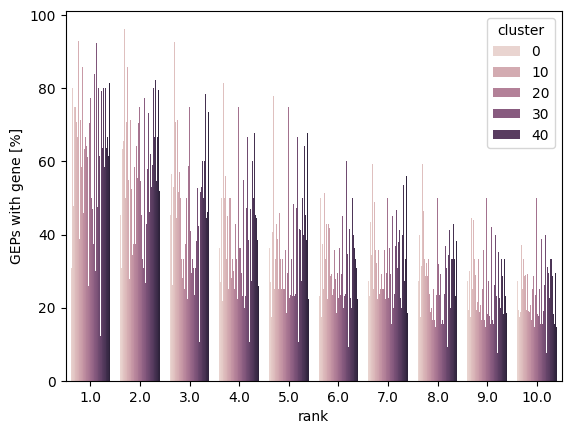

In [8]:
sns.barplot(data=top_10_gene_counts_df, x='rank', y='GEPs with gene [%]', hue='cluster')

In [39]:
gp = GProfiler(return_dataframe=True)

# Define a list of generic terms to exclude
EXCLUDE_TERMS = [
    "transcription", "RNA", "DNA", "gene expression",
    "chromatin modification", "biosynthetic",
    'metabolic'
]

def annotate_genes(gene_list, species="hsapiens"):
    """
    Annotates genes and filters out general transcription-related terms.
    
    Parameters:
    - gene_list: List of gene symbols.
    - species: Species (default: 'hsapiens').

    Returns:
    - A pandas DataFrame with filtered enrichment results.
    """
    # Run g:Profiler enrichment analysis
    results = gp.profile(
        query=gene_list,
        organism=species,
        sources=["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"]
    )

    # Filter out general transcription-related terms
    filtered_results = results[
        ~results["name"].str.contains("|".join(EXCLUDE_TERMS), case=False)
    ]
    
    return filtered_results

gene_list = top_10_gene_counts_df.loc[top_10_gene_counts_df['cluster'] == 35, 'gene'].tolist()
print(gene_list)
annotate_genes(gene_list)

['JUN', 'FOSB', 'JUND', 'FOS', 'JUNB', 'EGR1', 'KLF4', 'ATF3', 'CEBPD', 'MYC']


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
4,GO:CC,GO:0000785,chromatin,8.850443e-11,True,"""The ordered and organized complex of DNA, pro...",1368,10,10,22097,1.000,0.007310,query_1,"[GO:0005694, GO:0032993]"
18,GO:CC,GO:0005694,chromosome,3.079626e-09,True,"""A structure composed of a very long molecule ...",1949,10,10,22097,1.000,0.005131,query_1,[GO:0043232]
39,KEGG,KEGG:04380,Osteoclast differentiation,2.547250e-06,True,Osteoclast differentiation,132,8,5,8484,0.625,0.037879,query_1,[KEGG:00000]
41,GO:BP,GO:0140467,integrated stress response signaling,3.752466e-06,True,"""The series of molecular signals generated in ...",43,10,4,21031,0.400,0.093023,query_1,[GO:0033554]
43,GO:CC,GO:0005654,nucleoplasm,7.061763e-06,True,"""That part of the nuclear content other than t...",4220,10,10,22097,1.000,0.002370,query_1,"[GO:0031981, GO:0110165]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,GO:BP,GO:0034614,cellular response to reactive oxygen species,4.517901e-02,True,"""Any process that results in a change in state...",146,10,3,21031,0.300,0.020548,query_1,"[GO:0000302, GO:0034599, GO:1901701]"
144,GO:BP,GO:0006950,response to stress,4.760778e-02,True,"""Any process that results in a change in state...",3855,10,8,21031,0.800,0.002075,query_1,[GO:0050896]
145,GO:BP,GO:0009719,response to endogenous stimulus,4.826131e-02,True,"""Any process that results in a change in state...",1678,10,6,21031,0.600,0.003576,query_1,[GO:0050896]
146,GO:CC,GO:0044195,nucleoplasmic reticulum,4.995034e-02,True,"""Long, dynamic tubular channels, formed by inv...",1,10,1,22097,0.100,1.000000,query_1,"[GO:0005635, GO:0110165]"


In [38]:
['MYBL2', 'E2F8', 'E2F2', 'FOXM1', 'E2F1', 'E2F7', 'YBX1', 'HMGA1', 'MXD3', 'PHF19']

geps = gep_pca_df.loc[gep_pca_df['cluster'] == 30].index
gep_df.loc['E2F1', geps]

gep_adata_tf_TSP14_Vasculature_contractile cell_3        0.203017
gep_adata_tf_TSP21_Vasculature_contractile cell_4        0.000000
gep_adata_tf_TSP14_Vasculature_endothelial cell_4        0.101612
gep_adata_tf_TSP1_Bladder_endothelial cell_4             0.000000
gep_adata_tf_TSP21_Uterus_endothelial cell_4             0.137579
gep_adata_tf_TSP11_Bone_Marrow_innate lymphoid cell_1   -0.022421
gep_adata_tf_TSP20_Stomach_myeloid leukocyte_1           0.107315
gep_adata_tf_TSP11_Bone_Marrow_t cell_4                  0.152739
gep_adata_tf_TSP14_Blood_t cell_4                        0.400936
gep_adata_tf_TSP14_Lymph_Node_t cell_3                   0.173092
gep_adata_tf_TSP14_Prostate_t cell_4                     0.327335
gep_adata_tf_TSP14_Spleen_t cell_2                       0.141152
gep_adata_tf_TSP17_Liver_t cell_4                        0.050746
gep_adata_tf_TSP19_Liver_t cell_2                        0.279819
gep_adata_tf_TSP1_Blood_t cell_4                         0.304221
gep_adata_

In [28]:
gep_pca_df

,PCA1,PCA2,celltype,donor,tissue,cluster
gep_adata_tf_TSP10_Fat_contractile cell_0,0.719624,0.225700,contractile cell,TSP10,Fat,2
gep_adata_tf_TSP10_Fat_contractile cell_1,-0.609152,0.142517,contractile cell,TSP10,Fat,26
gep_adata_tf_TSP10_Fat_contractile cell_2,-0.102779,-0.243856,contractile cell,TSP10,Fat,22
gep_adata_tf_TSP10_Fat_contractile cell_3,0.120650,-0.089694,contractile cell,TSP10,Fat,13
gep_adata_tf_TSP10_Fat_contractile cell_4,-0.232141,-0.126003,contractile cell,TSP10,Fat,32
...,...,...,...,...,...,...
gep_adata_tf_TSP27_Muscle_t cell_0,0.068954,-0.080662,t cell,TSP27,Muscle,9
gep_adata_tf_TSP27_Muscle_t cell_1,-0.183603,0.316466,t cell,TSP27,Muscle,14
gep_adata_tf_TSP27_Muscle_t cell_2,0.087186,-0.213919,t cell,TSP27,Muscle,49
gep_adata_tf_TSP27_Muscle_t cell_3,0.336204,-0.371271,t cell,TSP27,Muscle,5


In [31]:
geps = gep_pca_df.loc[gep_pca_df['cluster'] == 30].index
geps

Index(['gep_adata_tf_TSP14_Vasculature_contractile cell_3',
       'gep_adata_tf_TSP21_Vasculature_contractile cell_4',
       'gep_adata_tf_TSP14_Vasculature_endothelial cell_4',
       'gep_adata_tf_TSP1_Bladder_endothelial cell_4',
       'gep_adata_tf_TSP21_Uterus_endothelial cell_4',
       'gep_adata_tf_TSP11_Bone_Marrow_innate lymphoid cell_1',
       'gep_adata_tf_TSP20_Stomach_myeloid leukocyte_1',
       'gep_adata_tf_TSP11_Bone_Marrow_t cell_4',
       'gep_adata_tf_TSP14_Blood_t cell_4',
       'gep_adata_tf_TSP14_Lymph_Node_t cell_3',
       'gep_adata_tf_TSP14_Prostate_t cell_4',
       'gep_adata_tf_TSP14_Spleen_t cell_2',
       'gep_adata_tf_TSP17_Liver_t cell_4',
       'gep_adata_tf_TSP19_Liver_t cell_2', 'gep_adata_tf_TSP1_Blood_t cell_4',
       'gep_adata_tf_TSP1_Lung_t cell_3', 'gep_adata_tf_TSP21_Eye_t cell_2',
       'gep_adata_tf_TSP25_Blood_t cell_3', 'gep_adata_tf_TSP25_Fat_t cell_3',
       'gep_adata_tf_TSP25_Lymph_Node_t cell_3',
       'gep_adata_tf_TSP2

NOTES:

instead of clustering on z-scores, make a cutoff. Take top10 and bottom 10 and caclulate adjacency matrix assigning overlap score.